# Feature Distributions by Precipitation Level
This notebook visualizes the distribution of each feature, grouped by precipitation level (e.g., 0-5mm, 5-25mm, 25-50mm, 50+mm).

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

# Set your dataset path
dataset_path = '/home/rionowcast/atmoseer/src/output_17_07.nc'  # Change if needed
if not Path(dataset_path).exists():
    raise FileNotFoundError(f'Dataset not found: {dataset_path}')
ds = xr.open_dataset(dataset_path)
print('✅ Dataset loaded:', dataset_path)

# Extract features (x) and target (y)
x = ds['x'].values  # (sample, time, lat, lon, channel)
y = ds['y'].values  # (sample, time, lat, lon, channel)

# Use only the first channel of y (precipitation)
y_precip = y[..., 0]  # (sample, time, lat, lon)
# Flatten all spatial and temporal dims
y_flat = y_precip.flatten()
# Define precipitation bins
bins = [0, 5, 25, 50, np.inf]
labels = ['0-5mm', '5-25mm', '25-50mm', '50+mm']
y_cats = np.digitize(y_flat, bins, right=False) - 1  # 0,1,2,3

# Prepare features
n_features = x.shape[-1]
feature_names = ds.channel.values if 'channel' in ds.coords else [f'Ch_{i}' for i in range(n_features)]
# Flatten features to match y_flat
x_flat = x.reshape(-1, n_features)  # (N, n_features)

✅ Dataset loaded: /home/rionowcast/atmoseer/src/output_17_07.nc


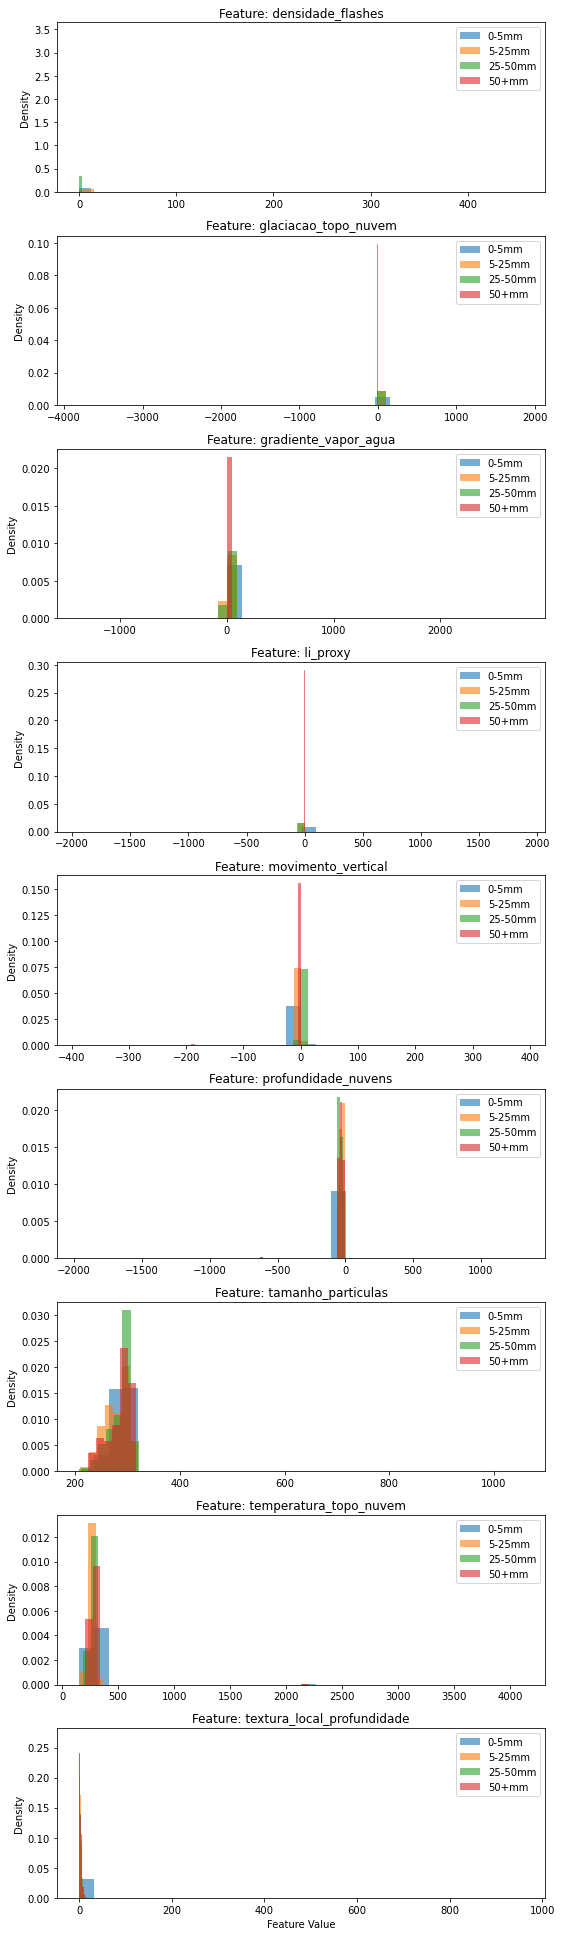

In [2]:
# Plot feature distributions by precipitation level
fig, axes = plt.subplots(n_features, 1, figsize=(8, 3 * n_features), sharex=False)
if n_features == 1:
    axes = [axes]
for i, ax in enumerate(axes):
    for cat_idx, label in enumerate(labels):
        mask = (y_cats == cat_idx)
        data = x_flat[mask, i]
        if len(data) > 0:
            ax.hist(data, bins=30, alpha=0.6, label=label, density=True)
    ax.set_title(f'Feature: {feature_names[i]}')
    ax.set_ylabel('Density')
    ax.legend()
plt.xlabel('Feature Value')
plt.tight_layout()
plt.show()

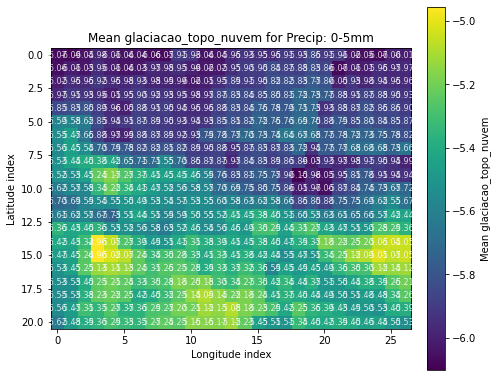

In [3]:
# Spatial heatmap: mean feature value by grid cell for a selected precipitation level
import matplotlib.pyplot as plt
import numpy as np

# --- User options ---
feature_idx = 1  # Change to select feature (0, 1, ... n_features-1)
precip_cat = 0  # Change to select precipitation bin: 0=0-5mm, 1=5-25mm, 2=25-50mm, 3=50+mm
feature_name = feature_names[feature_idx] if feature_idx < len(feature_names) else f'Ch_{feature_idx}'
precip_label = labels[precip_cat] if precip_cat < len(labels) else f'Cat_{precip_cat}'

# --- Prepare mask and data ---
x_shape = x.shape  # (sample, time, lat, lon, channel)
n_lat, n_lon = x_shape[2], x_shape[3]
mask = (y_cats == precip_cat)
x_selected = x_flat[mask, feature_idx]  # (N_selected,)
if x_selected.size == 0:
    print(f'No data for precipitation bin: {precip_label}')
else:
    # Get indices in the original (sample, time, lat, lon) space
    idx_flat = np.where(mask)[0]
    # Map flat indices to (sample, time, lat, lon)
    idx_multi = np.unravel_index(idx_flat, x_shape[:4])
    lat_idx, lon_idx = idx_multi[2], idx_multi[3]
    # Create 2D array for mean feature value at each (lat, lon)
    grid = np.full((n_lat, n_lon), np.nan)
    for i in range(n_lat):
        for j in range(n_lon):
            vals = x_selected[(lat_idx == i) & (lon_idx == j)]
            if len(vals) > 0:
                grid[i, j] = np.nanmean(vals)

    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(grid, cmap='viridis', aspect='equal')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label=f'Mean {feature_name}')
    ax.set_title(f'Mean {feature_name} for Precip: {precip_label}')

    # Overlay value labels
    for i in range(n_lat):
        for j in range(n_lon):
            val = grid[i, j]
            if not np.isnan(val):
                ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white', fontsize=8, alpha=0.8)

    plt.xlabel('Longitude index')
    plt.ylabel('Latitude index')
    plt.tight_layout()
    plt.show()

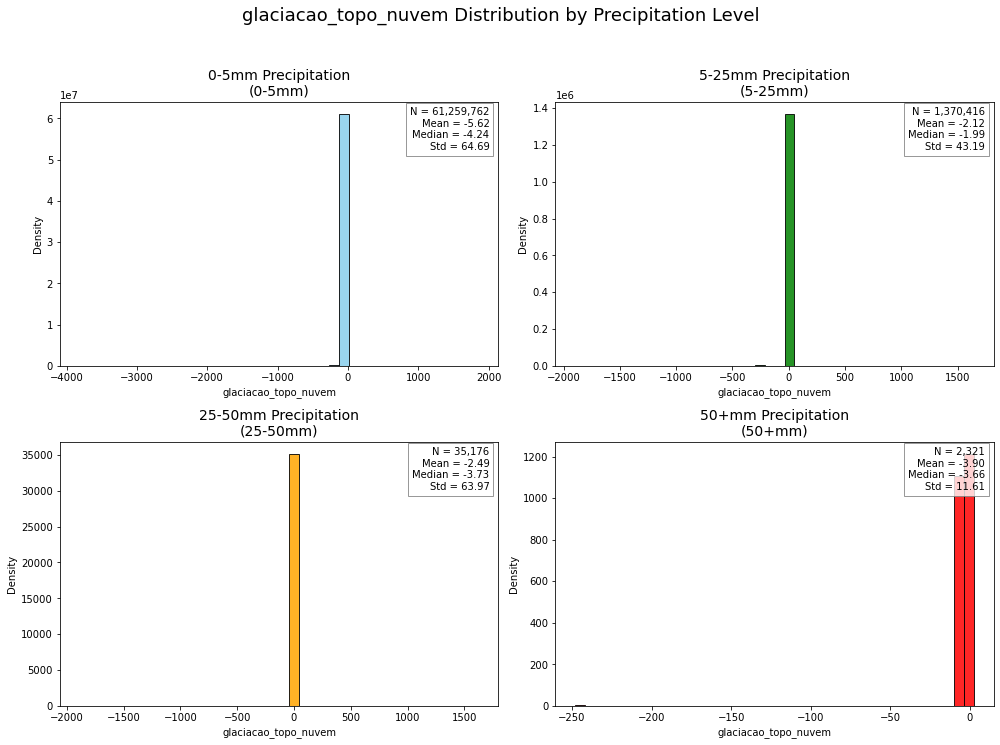

In [11]:
# 2x2 grid: Feature 0 distribution by precipitation level, with stats box (like example image)
import matplotlib.pyplot as plt
import numpy as np

feature_idx = 1  # Cloud Depth or other feature
feature_name = feature_names[feature_idx] if feature_idx < len(feature_names) else f'Ch_{feature_idx}'
bin_colors = ['skyblue', 'green', 'orange', 'red']  # Custom colors for each bin

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for cat_idx, ax in enumerate(axes):
    mask = (y_cats == cat_idx)
    data = x_flat[mask, feature_idx]
    color = bin_colors[cat_idx] if cat_idx < len(bin_colors) else 'gray'
    label = labels[cat_idx] if cat_idx < len(labels) else f'Cat_{cat_idx}'
    
    if len(data) > 0:
        ax.hist(data, bins=40, color=color, edgecolor='k', alpha=0.85)
        mean = np.nanmean(data)
        median = np.nanmedian(data)
        std = np.nanstd(data)
        N = len(data)
        stats_text = f'N = {N:,}\nMean = {mean:.2f}\nMedian = {median:.2f}\nStd = {std:.2f}'
        ax.text(0.98, 0.98, stats_text, ha='right', va='top', transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    
    ax.set_title(f'{label.split()[0].capitalize()} Precipitation\n({label})', fontsize=14)
    ax.set_ylabel('Density')
    ax.set_xlabel(feature_name)
    ax.grid(False)

fig.suptitle(f'{feature_name} Distribution by Precipitation Level', fontsize=18, y=1.03)
plt.tight_layout()
plt.show()

In [7]:
# Plot feature distributions by precipitation level, removing outliers (IQR method)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import xarray as xr
from pathlib import Path

# Set your dataset path
dataset_path = '/home/rionowcast/atmoseer/src/output_sum.nc'  # Change if needed
if not Path(dataset_path).exists():
    raise FileNotFoundError(f'Dataset not found: {dataset_path}')
ds = xr.open_dataset(dataset_path)
print('✅ Dataset loaded:', dataset_path)

# Extract features (x) and target (y)
x = ds['x'].values  # (sample, time, lat, lon, channel)
y = ds['y'].values  # (sample, time, lat, lon, channel)

# Use only the first channel of y (precipitation)
y_precip = y[..., 0]  # (sample, time, lat, lon)
# Flatten all spatial and temporal dims
y_flat = y_precip.flatten()
# Define precipitation bins
bins = [0, 5, 25, 50, np.inf]
labels = ['0-5mm', '5-25mm', '25-50mm', '50+mm']
y_cats = np.digitize(y_flat, bins, right=False) - 1  # 0,1,2,3

# Prepare features
n_features = x.shape[-1]
feature_names = ds.channel.values if 'channel' in ds.coords else [f'Ch_{i}' for i in range(n_features)]
# Flatten features to match y_flat
x_flat = x.reshape(-1, n_features)  # (N, n_features)

feature_idx = 0  # Change to select feature
feature_name = feature_names[feature_idx] if feature_idx < len(feature_names) else f'Ch_{feature_idx}'
bin_colors = ['skyblue', 'green', 'orange', 'red']  # Custom colors for each bin

def remove_outliers_iqr(data):
    if len(data) < 10:
        return data
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return data[(data >= lower) & (data <= upper)]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for cat_idx, ax in enumerate(axes):
    mask = (y_cats == cat_idx)
    data = x_flat[mask, feature_idx]
    data = data[np.isfinite(data)]
    data = data[data != 0]  # <-- Remove zeros here
    data = remove_outliers_iqr(data)
    color = bin_colors[cat_idx] if cat_idx < len(bin_colors) else 'gray'
    label = labels[cat_idx] if cat_idx < len(labels) else f'Cat_{cat_idx}'

    # Add this block to disable scientific notation
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.ticklabel_format(style='plain', axis='both')

    if len(data) > 0:
        ax.hist(data, bins=40, color=color, edgecolor='k', alpha=0.85)
        mean = np.nanmean(data)
        median = np.nanmedian(data)
        std = np.nanstd(data)
        N = len(data)
        stats_text = f'N = {N:,}\nMean = {mean:.2f}\nMedian = {median:.2f}\nStd = {std:.2f}'
        ax.text(0.98, 0.98, stats_text, ha='right', va='top', transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    ax.set_title(f'{label.split()[0].capitalize()} Precipitation\n({label})', fontsize=14)
    ax.set_ylabel('Count')
    ax.set_xlabel(feature_name)
    ax.grid(False)

fig.suptitle(f'Distribuição por nível de precipitação - {feature_name} (sem outliers)', fontsize=18, y=1.03)
plt.tight_layout()
plt.show()

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
✅ Dataset loaded: /home/rionowcast/atmoseer/src/output_sum.nc


KeyError: "No variable named 'y'. Variables on the dataset include ['x']"

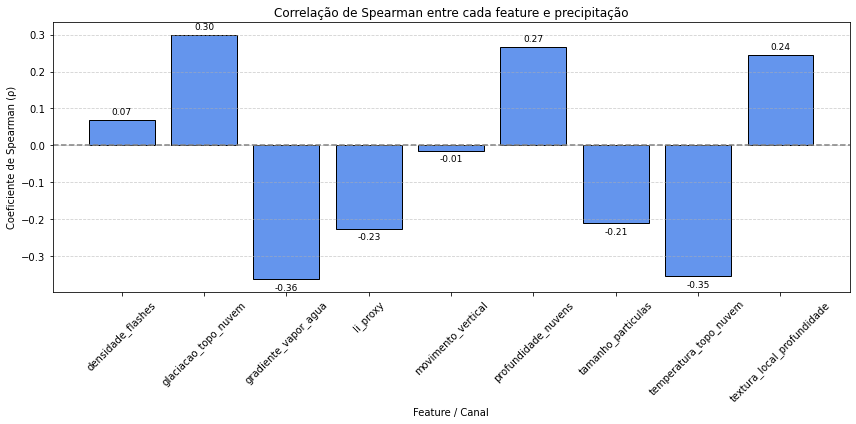

In [6]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Remove valores inválidos (NaN ou inf)
mask = np.isfinite(y_flat) & np.all(np.isfinite(x_flat), axis=1)
x_valid = x_flat[mask]
y_valid = y_flat[mask]

# Lista para armazenar os resultados
correlations = []
p_values = []

# Calcula Spearman para cada feature
for i in range(n_features):
    feat = x_valid[:, i]
    rho, pval = spearmanr(feat, y_valid)
    correlations.append(rho)
    p_values.append(pval)

# Nomes das features
feature_labels = list(feature_names) if len(feature_names) == n_features else [f'Ch_{i}' for i in range(n_features)]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(feature_labels, correlations, color='cornflowerblue', edgecolor='k')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Correlação de Spearman entre cada feature e precipitação')
plt.ylabel('Coeficiente de Spearman (ρ)')
plt.xlabel('Feature / Canal')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adiciona rótulos com os valores de correlação
for bar, rho in zip(bars, correlations):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01*np.sign(height), f'{rho:.2f}', 
             ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()
